In [4]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from pyunicorn.timeseries import RecurrencePlot, JointRecurrencePlot
from pyunicorn.timeseries.surrogates import Surrogates

# Adjacency Matrix

This script calculates the adjacency matrix for a set of time series based on either the Pearson correlation coefficient, joint recurrences (or mututal information).

To do this the following is done:

1. From `N` time series of length `T`, a set of `S` surrogates is generated.
2. For each pair of time series a correlation metric is calculated.
   2.1. The Pearson correlation coeffcient.
   2.2. A join recurrence metric (STILL DECIDE ON THIS)
3. From the metric's distribution over the surrogate data, it is determined what values for the real time series are statistically significant and should be kept.
4. A network adjacency matrix is build from the statistically significant combinations of time series.

### Generate Example Timeseries

In [187]:
T = 100
N = 50

# create N time series of length T for test purposes:
t = np.linspace(0, 1, T)
ys = np.random.random(size=(N, T))

# put some equal time series that should be detected
ys[10] = ys[36] = np.sin(5*t)
ys[24] = -ys[10]

print(f"{ys.shape[0]} time series with length {ys.shape[1]}")

50 time series with length 100


### Generate the Surrogates

### Building the Adjecency Matrix

In [240]:
def pearson (yi, yj):
    return sp.stats.pearsonr(yi, yj)[0]

def rmd (yi, yj, metric="euclidean", normalize=True, recurrence_rate=0.1, **kwargs):

    # individual recurrence plots
    irp = RecurrencePlot(yi, metric, normalize, recurrence_rate=recurrence_rate, silence_level=10, **kwargs)
    jrp = RecurrencePlot(yj, metric, normalize, recurrence_rate=recurrence_rate, silence_level=10, **kwargs)

    # calculate the column recurrence rate
    Pij = np.mean(irp.recurrence_matrix() * jrp.recurrence_matrix(), axis=1)
    Pi  = np.mean(irp.recurrence_matrix(), axis=1)
    Pj  = np.mean(jrp.recurrence_matrix(), axis=1)

    # calculate the recurrence based measure of dependence
    rmd = np.log2(np.sum(Pij/(Pi*Pj)))
    return rmd

def adjecency_matrix(ys, S=100, metric=pearson, **kwargs):

    # how many individual time series
    N = len(ys)

    # empty adjacency adjacency matrix
    A = np.zeros((N, N))

    ysrgs = ys.copy() #np.tile(yj, (S, 1))
    ysrgs = Surrogates(ysrgs, silence_level=10).twin_surrogates(ysrgs, dimension=1, delay=0, threshold=0.01)

    for i ,yi in enumerate(ys):
        for j, yj in enumerate(ys):
            if (i > j):
                A[i, j] = metric(yi, yj, **kwargs)

    return A + A.T

def random_surrogates(ys, S):
    return adjecency_matrix(Surrogates(np.random.randint(0, len(ys), S), silence_level=10).twin_surrogates(ys, 1, 0, 0.01))

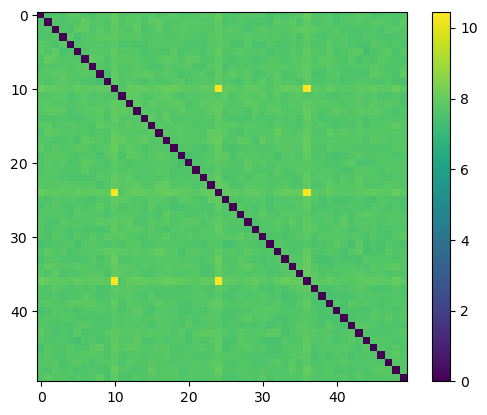

In [260]:
A = adjecency_matrix(ys, metric=rmd)
plt.imshow(A)
plt.colorbar()

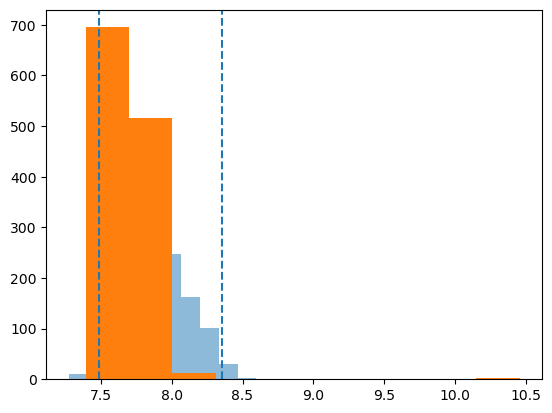

In [283]:
B = adjecency_matrix(random_surrogates(ys, 1000), metric=rmd)
B = B[np.triu_indices(len(B), k=1)]

q = np.quantile(B, [0.025, 0.975])

plt.hist(B, alpha=0.5)
plt.hist(A[np.triu_indices(len(A), k=1)])
plt.axvline(q[0], ls="--")
plt.axvline(q[1], ls="--")

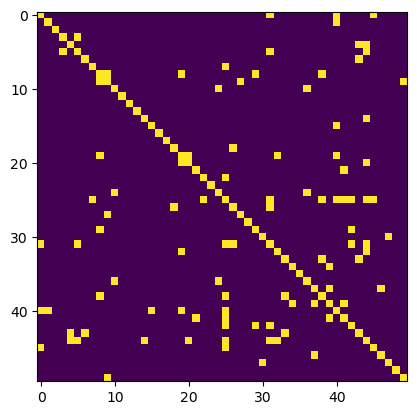

In [284]:
plt.imshow((A < q[0]) | (q[1] < A))